In [1]:
import os
import csv
import pandas as pd
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math


import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils import data as tdata
from torchvision import utils as vutils, transforms as T
from torchvision.datasets import ImageFolder

from transformers import AutoImageProcessor, CvtForImageClassification
import pytorch_lightning as pl

In [2]:
# defining the number of GPUs because PL makes it very easy for us to
# parallelize training across multiple GPUs
num_devices = torch.cuda.device_count()
num_devices

2

In [3]:
random_seed = 42
pl.seed_everything(random_seed)

42

In [4]:
hugging_model_name = "microsoft/cvt-13"
image_processor = AutoImageProcessor.from_pretrained(hugging_model_name)
image_processor

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# # Define input and output paths
# input_path = "/kaggle/input/indian-sign-language-isl/Indian"
# output_path = "/kaggle/train-test-split"

# # Define input and output paths
input_path = "/kaggle/input/renamed-indian-sign-language-dataset/indian-sign-language-dataset/ISL_Dataset"
output_path = "/kaggle/train-test-split"


train_dir = os.path.join(output_path, "train")
test_dir = os.path.join(output_path, "test")

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all class folders
classes = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]

# Train-test split ratio
test_size = 0.1

for class_name in classes:
    class_path = os.path.join(input_path, class_name)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Split images into training and testing
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    # Create class directories in train and test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move images to the corresponding directories
    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, class_name))
    for img in test_images:
        shutil.copy(img, os.path.join(test_dir, class_name))

print(f"Data split complete! Training data is in '{train_dir}', and testing data is in '{test_dir}'.")


Data split complete! Training data is in '/kaggle/train-test-split/train', and testing data is in '/kaggle/train-test-split/test'.


In [6]:
train_path = '/kaggle/train-test-split/train'
kaggle_write_path = '/kaggle/working/'
mean, std = image_processor.image_mean, image_processor.image_std
img_size = image_processor.size

In [7]:
def get_dirs(root_path):
    """
        Returns `(list_classes, classes_to_idx, numpy array mapping path to class_idx)
    """
    if not os.path.exists(root_path):
        raise FileNotFoundError("Folder does not exist")
        
    classes = sorted(os.listdir(root_path))
    classes_to_idx = {c: i for i, c in enumerate(classes)}
    
    all_samples = []
    
    for idx, cl in enumerate(classes):
        path = os.path.join(root_path, cl)
        
        all_files = os.listdir(path)
        
        # add `(path, class_idx)` to all_samples
        all_samples.extend([[p, idx] for p in all_files])

    all_samples = np.array(all_samples)
    
    return classes, classes_to_idx, all_samples
    
all_classes, classes_to_idx, all_samples = get_dirs(train_path)

In [8]:
classes_to_idx

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'O': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'U': 18,
 'V': 19,
 'W': 20,
 'X': 21,
 'Z': 22}

In [9]:
print(f"Number of samples: {len(all_samples)}")
train_ratio = 0.8
train_samples, test_samples = train_test_split(all_samples, shuffle=True, train_size=train_ratio)
print(f"Length of splits: {len(train_samples)}, {len(test_samples)}")
train_samples[0], test_samples[0]

Number of samples: 623
Length of splits: 498, 125


(array(['240.jpg', '7'], dtype='<U21'), array(['276.jpg', '8'], dtype='<U21'))

In [10]:
class CustomDataset(tdata.Dataset):
    def __init__(self, root_path, samples, classes, transform=None, transform_args=[]):
        """_summary_

        Args:
            root_path (_type_): path from where data will be read. Like `ImageFolder`, pass in folder path where folders inside it will be treated as classes.
            samples (_type_): a numpy array that will have rows that map `(image_path, class_idx)`
            classes (_type_): a list of all class names
            transform (_type_, optional): If provided, can be torch transforms or 🤗 image processors. Defaults to None.
            transform_args (list, optional): Is a list of `(argument, value)`. Defaults to [].
        """
        
        self.root_path = root_path
        self.samples = samples
        self.transform = transform
        self.classes = classes
        print(classes)
        self.transform_args = {}
        for key, val in transform_args:
            self.transform_args[key] = val
        
        print(self.transform_args)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        file_name, target = self.samples[idx]
        target = int(target)
        file_path = os.path.join(self.root_path, self.classes[target], file_name)
        img = io.imread(file_path)
        
        if self.transform is not None:
            img = self.transform(img, **self.transform_args)
        
        return img["pixel_values"][0], target

In [11]:
idx_to_class = {i: d for (i, d) in enumerate(all_classes)}
num_classes = len(all_classes)
str([num_classes, idx_to_class])

"[23, {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'O', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'U', 19: 'V', 20: 'W', 21: 'X', 22: 'Z'}]"

In [12]:
transform_args = [("return_tensors", 'pt')]

train_dataset = CustomDataset(
    train_path, train_samples, all_classes, transform=image_processor, transform_args=transform_args)
valid_dataset = CustomDataset(train_path, test_samples, all_classes,
                              transform=image_processor, transform_args=transform_args)
len(train_dataset), len(valid_dataset)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Z']
{'return_tensors': 'pt'}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Z']
{'return_tensors': 'pt'}


(498, 125)

In [13]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [14]:
def denorm(tensor, mean=mean, std=std):
  """This denormalises the tensor so that we can use it to plot normalised images"""
  mean, std = torch.tensor([mean]), torch.tensor([std])
  # print(mean.shape)
  output = std * tensor + mean
  return torch.clamp(output, 0, 1)

In [15]:
def plot_image(tensor, label=None, denormalise=True):
  """tensor is of shape `(h, w, c)`"""
  plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

  if label is not None:
    plt.title(str(label))
  
  if denormalise:
    tensor = denorm(tensor)
    tensor.permute(1, 2, 0)
    
  plt.imshow(tensor)

In [16]:
def plot_grid(tensor, n_row):
  """Input is of shape (batch_size, c, h, w)"""

  grid_tensor = vutils.make_grid(tensor, n_row).permute(1, 2, 0)
  plot_image(grid_tensor, "Grid of Random ISL Images")

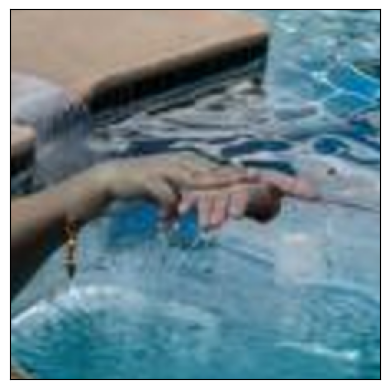

In [17]:
img = train_dataset[1][0].permute(1, 2, 0)
plot_image(img)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([128, 3, 224, 224])


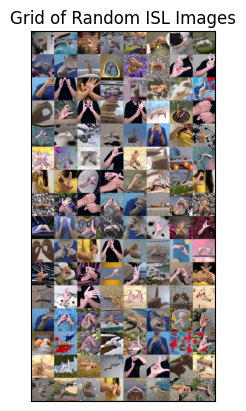

In [18]:
from torch.utils.data import BatchSampler, SequentialSampler

batch_size = 128

def get_loader(dataset, batch_size, num_workers=0):
    """Simple Utility function to instantiate a `DataLoader`."""
    
    persistent_workers = True if num_workers > 0 else False
    
    sampler = BatchSampler(SequentialSampler(dataset), batch_size, drop_last=False)
    return tdata.DataLoader(dataset, batch_sampler=sampler, 
                            num_workers=num_workers, 
                            # the below flag is necessary for it to not crash
                            persistent_workers=persistent_workers)

train_loader = get_loader(train_dataset, batch_size, 2)
valid_loader = get_loader(valid_dataset, batch_size, 2)

# check if the dataloader works fine by plotting a grid of images
for images, labels in train_loader:
    print(images.shape)
    plot_grid(images, 8)
    break

In [19]:
class CvTTrainingModule(pl.LightningModule):

  def __init__(self, num_labels: int, hugging_model_name: str, lr: int = 1e-4):
    super(CvTTrainingModule, self).__init__()
    self.cvt = CvtForImageClassification.from_pretrained(hugging_model_name, num_labels=num_labels,
                                                         id2label=idx_to_class, label2id=classes_to_idx,
                                                         ignore_mismatched_sizes=True)
    self.lr = lr

  def forward(self, pixel_values):
    outputs = self.cvt(pixel_values)
    return outputs["logits"]

  def common_step(self, batch):
    images, labels = batch
    outputs = self.cvt(images)["logits"]

    l = F.cross_entropy(outputs, labels)
    preds = torch.argmax(outputs, dim=-1)
    num_correct = (preds == labels).sum().item()
    accuracy = num_correct / len(batch)

    return l, accuracy

  def training_step(self, batch, batch_idx):

    l, accuracy = self.common_step(batch)

    self.log("training_loss", l)
    self.log("training_accuracy", accuracy)

    return l

  def validation_step(self, batch, batch_idx):
    l, accuracy = self.common_step(batch)

    self.log("val_loss", l)
    self.log("val_accuracy", accuracy)

    return l

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), self.lr)
    return optimizer

  def train_dataloader(self):
    return train_loader

  def val_dataloader(self):
    return valid_loader

In [20]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/lightning_logs/

In [21]:
# Define paths
custom_checkpoint_path = os.path.join(kaggle_write_path, 'custom.pth')
checkpoint_path = os.path.join(kaggle_write_path, "checkpoints")

# Define callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_path,
    save_top_k=2,  # Save top 2 models with the lowest validation loss
    every_n_train_steps=50,  # Save every 50 steps
    mode="min",  # Minimize the monitored metric
    monitor="val_loss",  # Monitor validation loss
    filename="{epoch:02d}-{val_loss:.2f}",  # Filename format
    verbose=True  # Log saving checkpoints
)

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=4,          # Stop after 5 epochs with no improvement
    verbose=True,        # Log when stopping
    mode='min'           # Minimize validation loss
)

# Define model
# num_classes = 35  # Replace with your number of classes
num_classes = 23  # Replace with your number of classes
hugging_model_name = "microsoft/cvt-13"

model = CvTTrainingModule(num_classes, hugging_model_name)

# Trainer arguments
num_devices = 1  # Set the number of GPUs
trainer_args = {
    "accelerator": "gpu",
    "devices": num_devices,
    "strategy": "auto",
    "log_every_n_steps": 5,
    "callbacks": [early_stop_callback, checkpoint_callback],
    "max_epochs": 30,
}

# Initialize Trainer
trainer = pl.Trainer(**trainer_args)

# Start training
# trainer.fit(model, ckpt_path=None)
trainer.fit(model, ckpt_path=None)

config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([23]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([23, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [22]:
import os

# Define the mapping for class names (1-9 and A-Z)
# classes_to_idx = {str(i): i - 1 for i in range(1, 10)}  # Map '1'-'9' to indices 0-8
# classes_to_idx.update({chr(i): i - ord('A') + 9 for i in range(ord('A'), ord('Z') + 1)})  # Map 'A'-'Z' to indices 9-34

# Define the mapping for class names (A-Z)
# classes_to_idx= {chr(i): i - ord('A') for i in range(ord('A'), ord('Z') + 1)}
test_path = '/kaggle/train-test-split/test'

samples = []
visual_samples = []
# Iterate through subfolders
for class_name in sorted(os.listdir(test_path)):
    class_folder = os.path.join(test_path, class_name)
    if os.path.isdir(class_folder):  # Ensure it's a directory
        idx = classes_to_idx[class_name]  # Map class name to index
        vis_taken = 0
        # Iterate through images in the subfolder
        for f in sorted(os.listdir(class_folder)):
            p = os.path.join(class_folder, f)
            if vis_taken == 0:
                visual_samples.append((p, idx))
                vis_taken = 1
            samples.append((p, idx))

print(f"Total samples: {len(samples)}")
print(f"Visual samples: {len(visual_samples)}")

Total samples: 79
Visual samples: 23


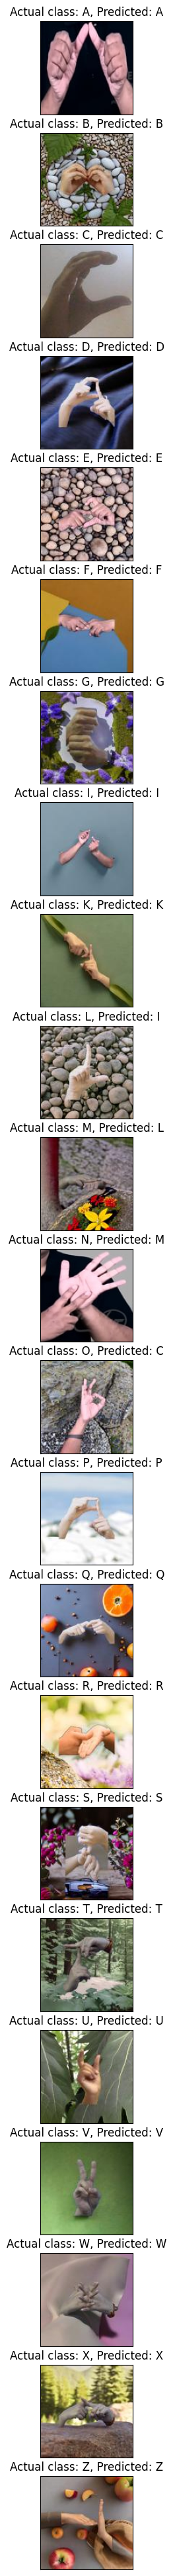

19

In [23]:
def perform_predictions(samples, model):
    """samples will be of the form `(path, target)`"""
    num_correct = 0
    
    fig, ax = plt.subplots(len(samples), sharey=True, figsize=(5, 50))
    model.eval()
    for curr_ax, (p, idx) in zip(ax, samples):
        img = io.imread(p)
        proc_img = image_processor(img, return_tensors="pt")["pixel_values"]
        outputs = model(proc_img)
        
        pred = torch.argmax(outputs, -1)
        if pred == idx:
            num_correct += 1
        
        target_class = all_classes[idx]
        curr_ax.title.set_text(f"Actual class: {target_class}, Predicted: {all_classes[pred]}")
        curr_ax.tick_params(bottom=False, left=False, labelleft=False,
                            labelright=False, labelbottom=False)
        curr_ax.imshow(img)
        
    plt.show()
    return num_correct
    
perform_predictions(visual_samples, model)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from tqdm import tqdm  # Optional, for progress display
from PIL import Image

def evaluate_model(samples, model, image_processor):
    """samples will be of the form `(path, target)`"""
    all_preds = []
    all_labels = []
    
    fig, ax = plt.subplots(len(samples), sharey=True, figsize=(5, 50))
    model.eval()
    for curr_ax, (p, idx) in zip(ax, samples):
        img = io.imread(p)
        proc_img = image_processor(img, return_tensors="pt")["pixel_values"]
        outputs = model(proc_img)
        
        pred = torch.argmax(outputs, -1)
        all_preds.append(pred)
        all_labels.append(idx)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

Accuracy: 0.8228
Precision: 0.8237
Recall: 0.8228
F1 Score: 0.8162


(0.8227848101265823,
 0.8236889692585895,
 0.8227848101265823,
 0.8162145871006632)

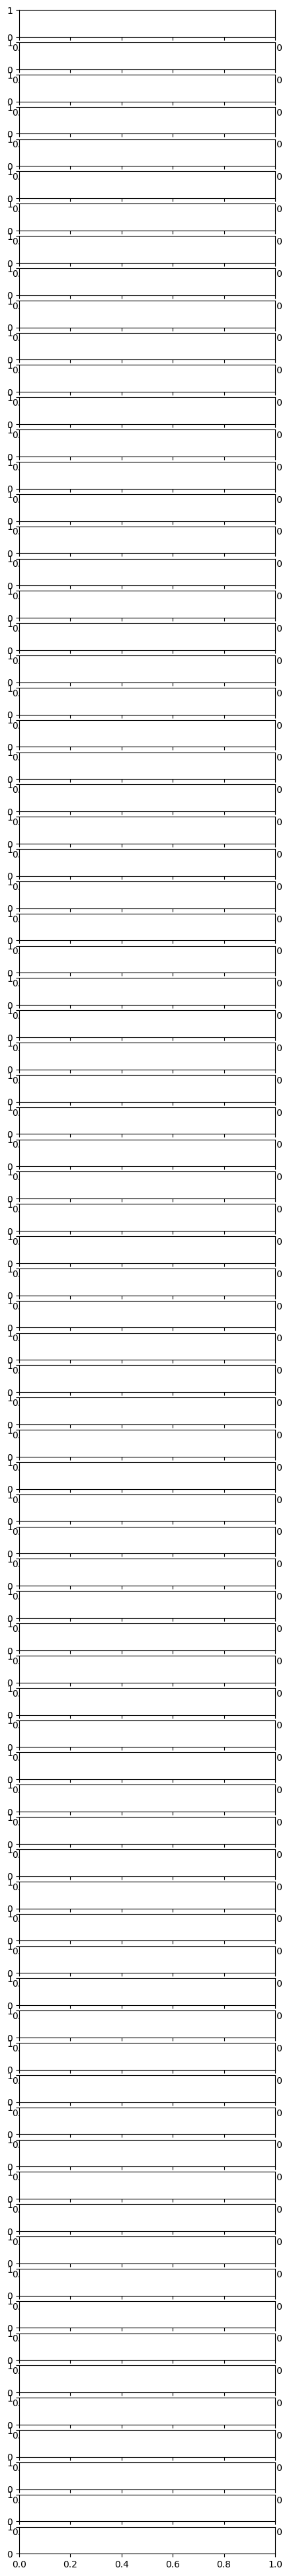

In [25]:
evaluate_model(samples, model, image_processor)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


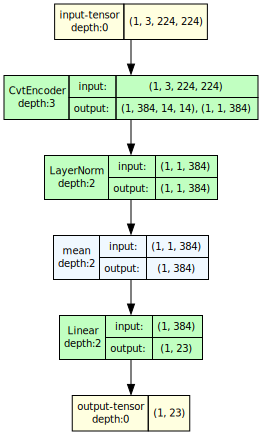

In [26]:
!pip install torchview
import random
from transformers import AutoModel
from torchview import draw_graph

random_sample = random.choice(samples)
image_path_random, label = random_sample

random_image = io.imread(image_path_random)
proc_rand_img = image_processor(random_image, return_tensors="pt")["pixel_values"]
outputs = model(proc_rand_img)

model_graph = draw_graph(model, input_data=proc_rand_img)

model_graph.visual_graph